# Heart Disease UCI

##  1. Problem Tanımı

**Projenin Amacı:**
Bu projenin temel amacı, bireylerin sahip olduğu klinik ve demografik özelliklere göre **kalp hastalığı riski** taşıyıp taşımadığını tahmin edebilen bir makine öğrenmesi modeli geliştirmektir.

**Hedef Değişken (`target`):**

* `0`: Kalp hastalığı yok
* `1`: Kalp hastalığı var
  Modelimizin temel görevi, bu ikili sınıflandırmayı mümkün olduğunca doğru biçimde yapmaktır.

**Problem Türü:**

* **İkili Sınıflandırma (Binary Classification)**
  Bu nedenle sınıflandırma algoritmaları (Lojistik Regresyon, Random Forest, XGBoost vb.) kullanılacaktır.

**Veri Setinin Kaynağı:**

* Veri, **Kaggle** platformunda yer alan UCI Heart Disease Dataset'ten alınmıştır.
* Veri seti 4 farklı klinikten (Cleveland, Hungary, Switzerland, VA Long Beach) toplanan gözlemleri içermektedir.

**Medikal Amaç:**
Kalp hastalıkları dünya çapında ölüm nedenlerinin başında gelmektedir. Bu çalışma ile klinik veriler kullanılarak **erken uyarı sistemleri** için temel oluşturabilecek, yorumlanabilir ve güvenilir bir tahmin mekanizması hedeflenmiştir.




## 2. Veri Setinin Genel Tanıtımı



*  Veri Seti 920 satır × 16 sütundan oluşur.

**Sayısal Değişkenler:**

* `age` → Yaş (yıl cinsinden)
* `trestbps` → Dinlenme sırasındaki kan basıncı (mm Hg)
* `chol` → Serum kolestrol düzeyi (mg/dl)
* `thalach` → Egzersiz sonrası ulaşılan maksimum kalp atış hızı
* `oldpeak` → Egzersize bağlı ST segmenti depresyonu (EKG sonucu)

**İkili Kategorik Değişkenler:**

* `sex` → Cinsiyet (0 = Kadın, 1 = Erkek)
* `fbs` → Açlık kan şekeri > 120 mg/dl (1 = Evet, 0 = Hayır)
* `exang` → Egzersize bağlı anjina (1 = Evet, 0 = Hayır)

**Çok Kategorili Değişkenler:**

* `cp` → Göğüs ağrısı tipi (0–3 arası sınıflar)
* `restecg` → Dinlenme elektrokardiyografisi sonuçları
* `slope` → ST segment eğimi
* `ca` → Floroskopide görülen büyük damar sayısı (0–3)
* `thal` → Talasemi tipi (normal, sabit kusur, ters kusur gibi)

---

###  Hedef Değişken:

* `target`: 1 = Kalp hastalığı var, 0 = yok
* Sınıf dağılımı kontrol edilerek **dengesizlik** analizi yapılmıştır.

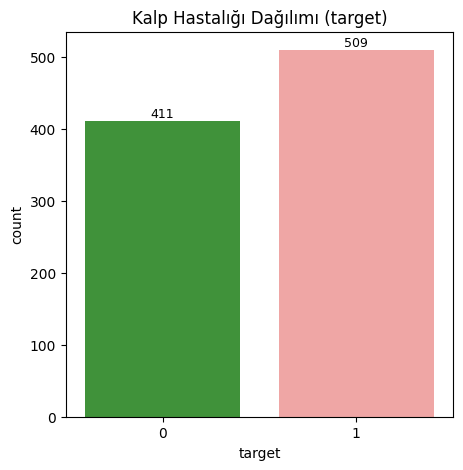

## Eksik Veri Analizi


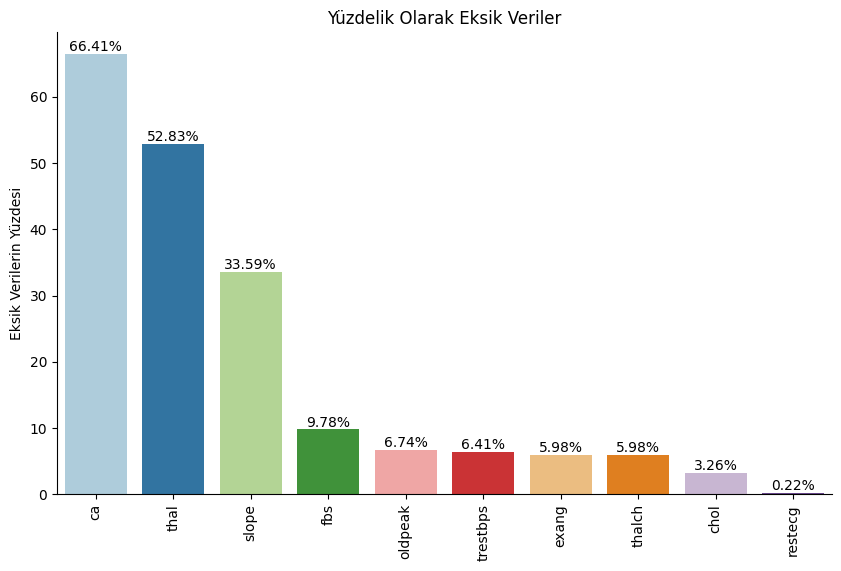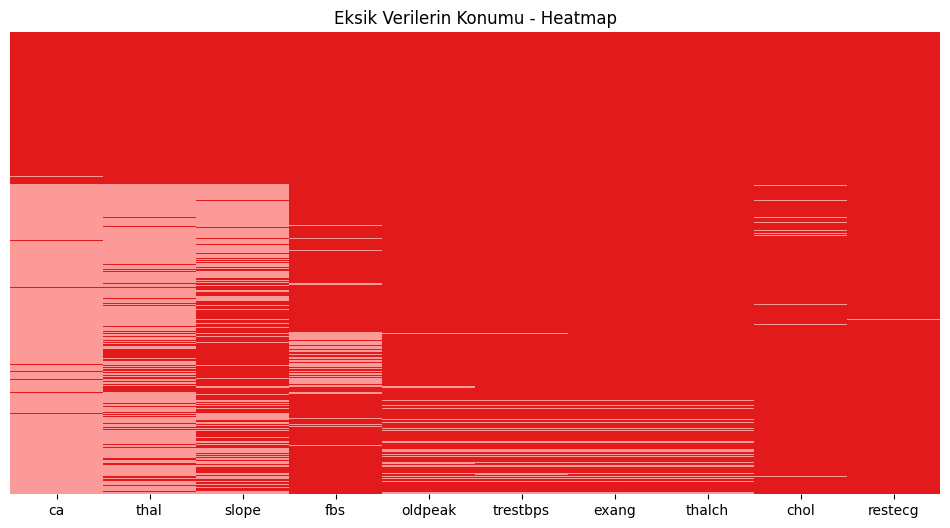
---



### Eksik Veri Türü Değerlendirmesi

Eksik veriler üç farklı yapıda olabilir:

- **MCAR (Missing Completely at Random):** Eksiklik tamamen rastgele, başka değişkenlerle ilişkili değil.
- **MAR (Missing at Random):** Eksiklik başka gözlemlenebilir değişkenlerle ilişkili.
- **MNAR (Missing Not at Random):** Eksiklik, doğrudan değişkenin kendisiyle ilgili.

---

### Çıkarılan Değişkenler

- `ca` (%66 eksik) ve `thal` (%53 eksik) sütunlarının eksiklik oranı çok yüksekti.
- Eksikliklerin sistematik (MNAR) olduğu düşünülerek modelden çıkarıldılar.

---

### Doldurulan Değişkenler ve Yöntemler

| Tür         | Değişkenler                                             | Yöntem                 |
|-------------|----------------------------------------------------------|------------------------|
| Sayısal     | trestbps, chol, thalch, oldpeak                         | KNNImputer (k=5)       |
| Kategorik   | slope, fbs, restecg, exang                               | Mod (en sık görülen)   |

- Sayısal değişkenlerde benzer gözlemlere göre tahmin yapılmıştır.
- Kategorik değişkenlerde en sık görülen değer ile doldurma yapılmıştır.

---


Eksik veriler veri tipine ve eksiklik oranına göre farklı stratejilerle ele alınmıştır. Modelin güvenilirliğini azaltabilecek yüksek oranlı ve sistematik eksikler veri setinden çıkarılmış, geri kalan eksikler uygun şekilde doldurulmuştur.


## Aykırı Değer Analizi


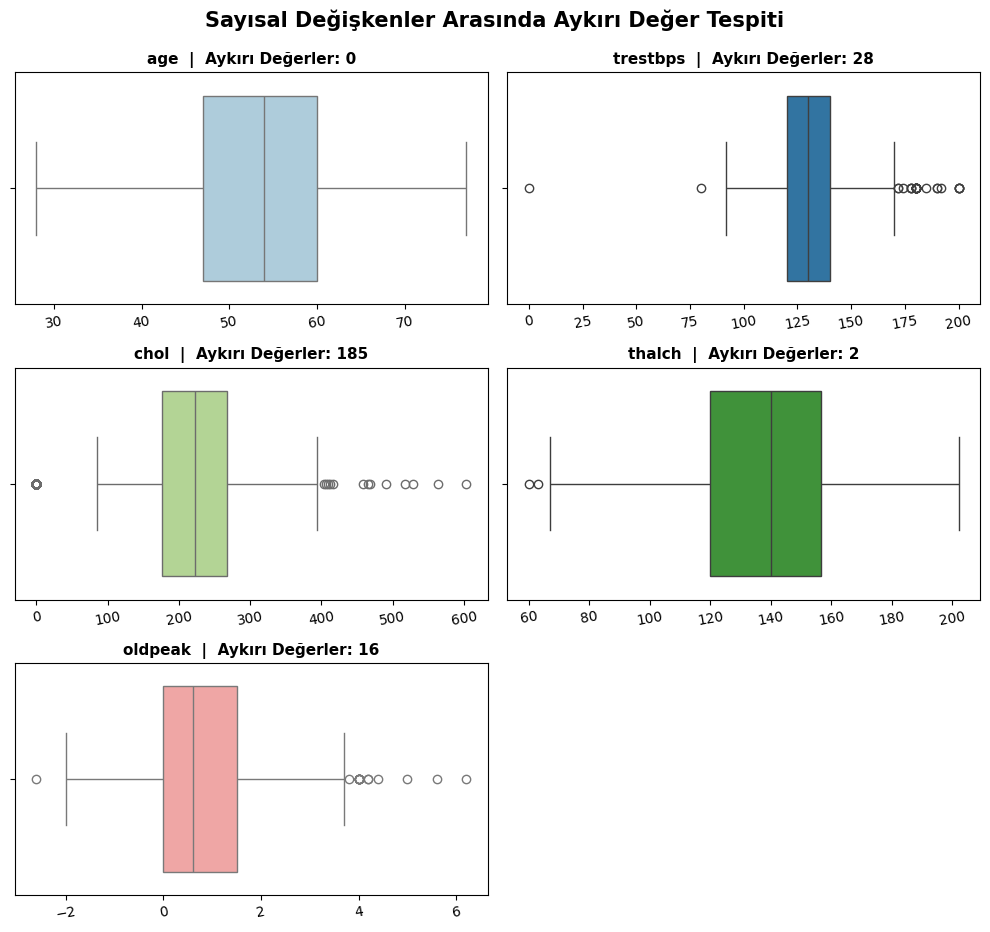





| Değişken | Aykırı Değer Sayısı | Uygulanan Yöntem                |
| -------- | ------------------- | ------------------------------- |
| age      | 0                   | Müdahale edilmedi               |
| trestbps | 28                  | Medyan ile değiştirildi         |
| chol     | 185                 | Winsorization (uç değer kırpma) |
| thalch   | 2                   | Korundu                         |
| oldpeak  | 16                  | Medyan ile değiştirildi         |


* **Winsorization:** `chol` değişkeninde uç değerlerin dağılıma olan etkisini azaltmak amacıyla IQR dışındaki değerler üst ve alt sınıra kırpıldı.
* **Medyanla Değiştirme:** `trestbps` ve `oldpeak` değişkenlerinde, sınır dışında kalan değerler yerine değişkenin medyanı yazıldı. Medikal verilerde, medyan değeri aşırı uçlara karşı daha dirençlidir.
* **Korumalı Değerler:** `thalch` değişkeninde yalnızca 2 adet aykırı gözlem vardı. Klinik olarak nadir ama anlamlı olabilecek bu değerler korunmuştur.

Bu işlemler sayesinde modelin genelleyici gücü korunurken, aykırı değerlerin bozucu etkisi de minimize edilmiştir.


## EDA

### Sayısal Değişkenlerde Korelasyon

Sayısal değişkenler arasında yapılan korelasyon analizi sonucunda hedef değişken `target` ile en yüksek ilişkili değişkenler aşağıda listelenmiştir:

* **thalch (maksimum kalp atış hızı):** -0.38 (negatif güçlü korelasyon)
* **oldpeak (ST depresyonu):** +0.37 (pozitif güçlü korelasyon)
* **age:** +0.28 (orta düzey ilişki)
* **chol:** -0.22 (zayıf/negatif ilişki)

Bu sonuçlar klinik olarak da anlamlıdır; örneğin, düşük thalch ve yüksek oldpeak kalp hastalığı riskini artırabilir.

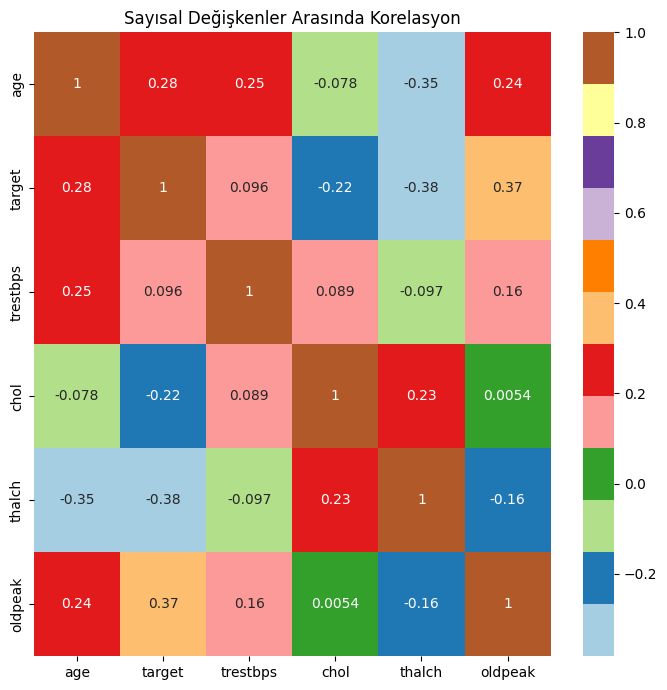



### Sayısal Değişkenlerin Dağılımı

Dağılım analizine göre:

* **age** ve **thalch** değişkenleri yaklaşık normal dağılım göstermektedir.
* **chol**, **oldpeak** ve **trestbps** değişkenleri sağa çarpık veya düzensiz dağılmıştır.
* Özellikle `chol` ve `oldpeak` değişkenleri için dönüşüm veya aykırı değer müdahalesi gerekmiştir.



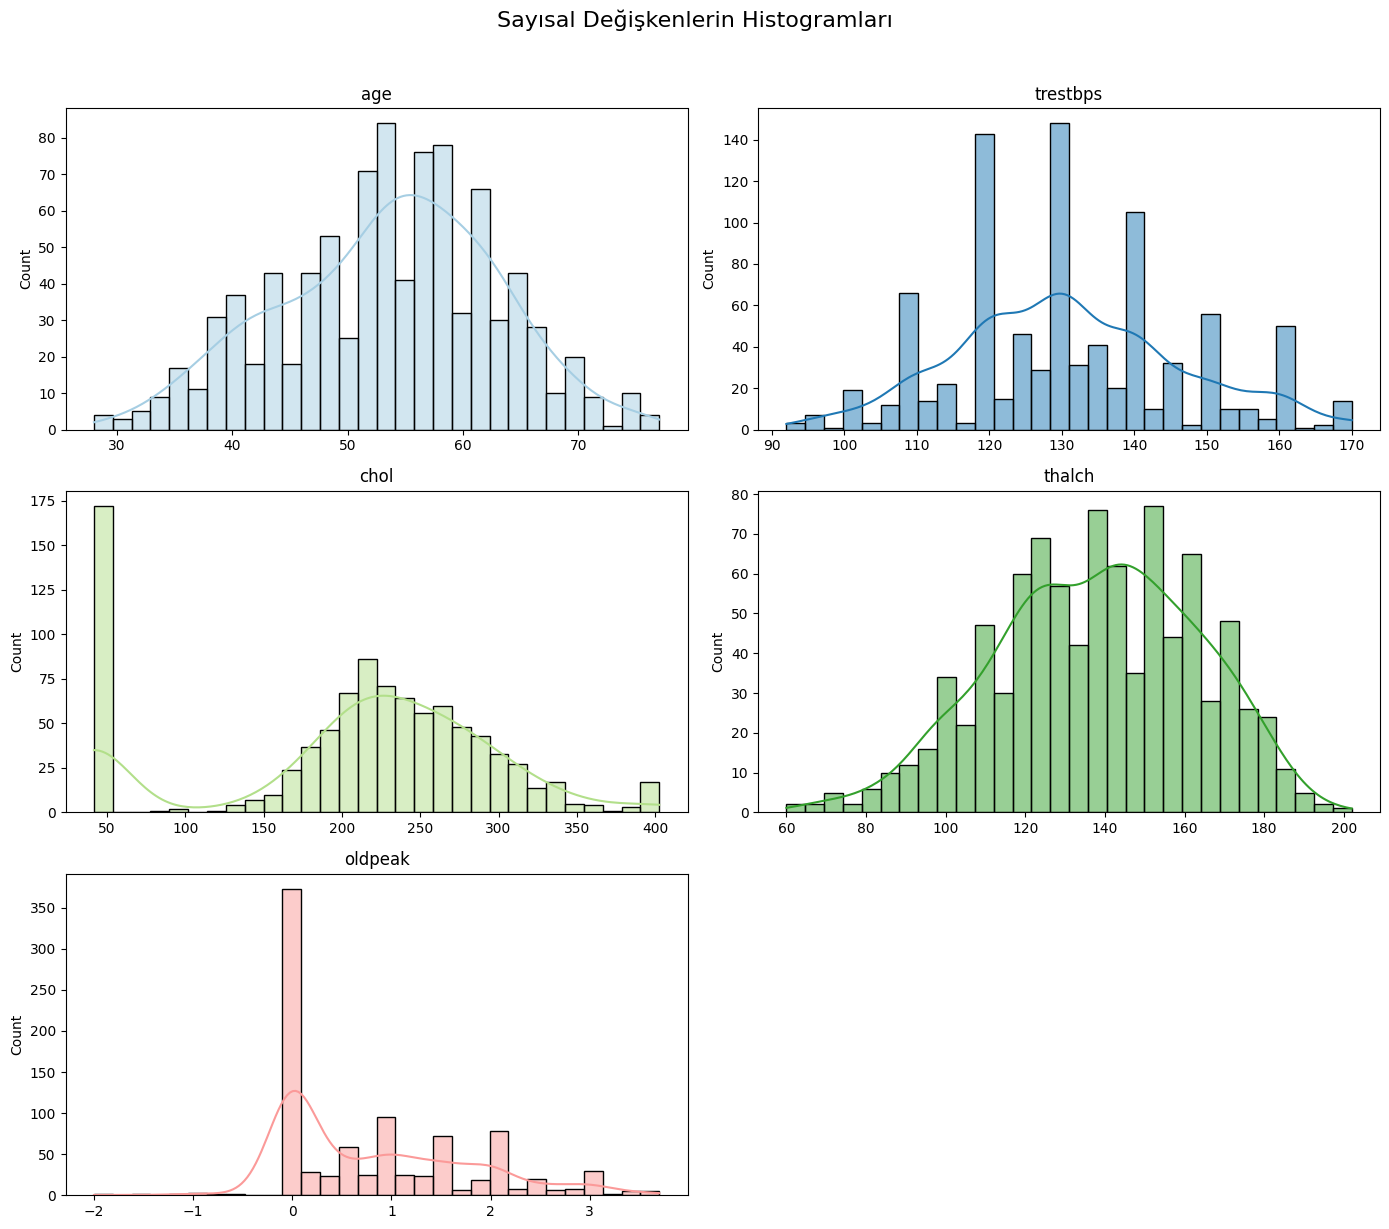

### Kategorik Değişkenlerde Sınıf Dağılımı

Kategorik sütunlarda gözlenen sınıf dengesizlikleri:

* `sex`: 726 erkek, 194 kadın
* `cp`: çoğunlukla "asymptomatic"
* `slope`: büyük ölçüde "flat"
* `fbs`, `exang`: çoğunlukla False

Bu dengesizlikler modelin belirli sınıflara karşı daha fazla duyarlılık göstermesine neden olabilir.



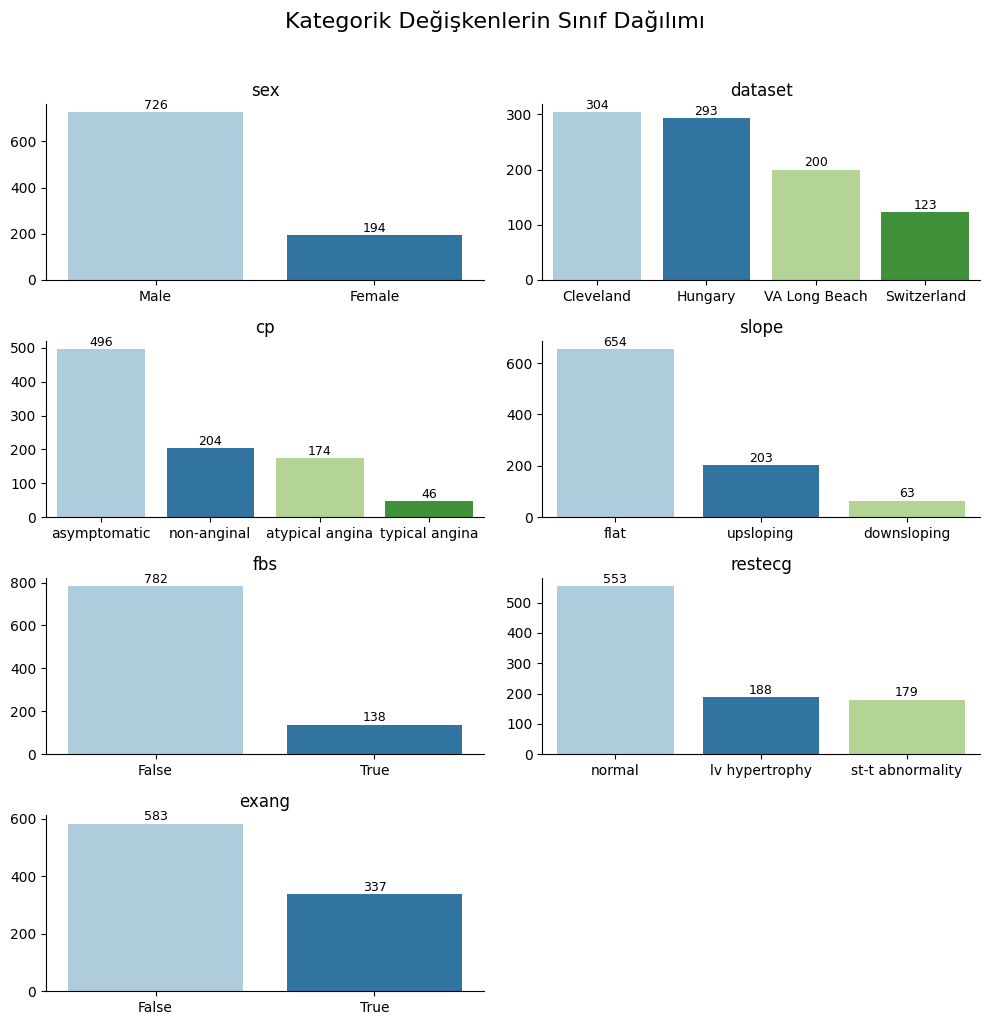

### Kategorik Değişkenlerde Kalp Hastalığı Oranı (target=1)

Kategorik değişkenlerin hastalıkla ilişkisi aşağıdaki gibidir:

* **sex:** Erkeklerde hastalık oranı daha yüksek
* **cp:** "Asymptomatic" türünde olanlarda hastalık oranı belirgin yüksek
* **exang:** Egzersizle anjina yaşayanlarda hastalık oranı çok daha fazladır
* **slope:** "Downsloping" olanlarda risk daha yüksektir

Bu gözlemler, özellikle `cp`, `exang` ve `slope` gibi değişkenlerin modele katkısının yüksek olduğunu göstermektedir.

Görselleştirmeler sayesinde hem dağılım yapıları hem de hedef değişkenle olan ilişkiler daha net anlaşılmış ve modellemede hangi değişkenlerin daha önemli olduğu belirlenmiştir.


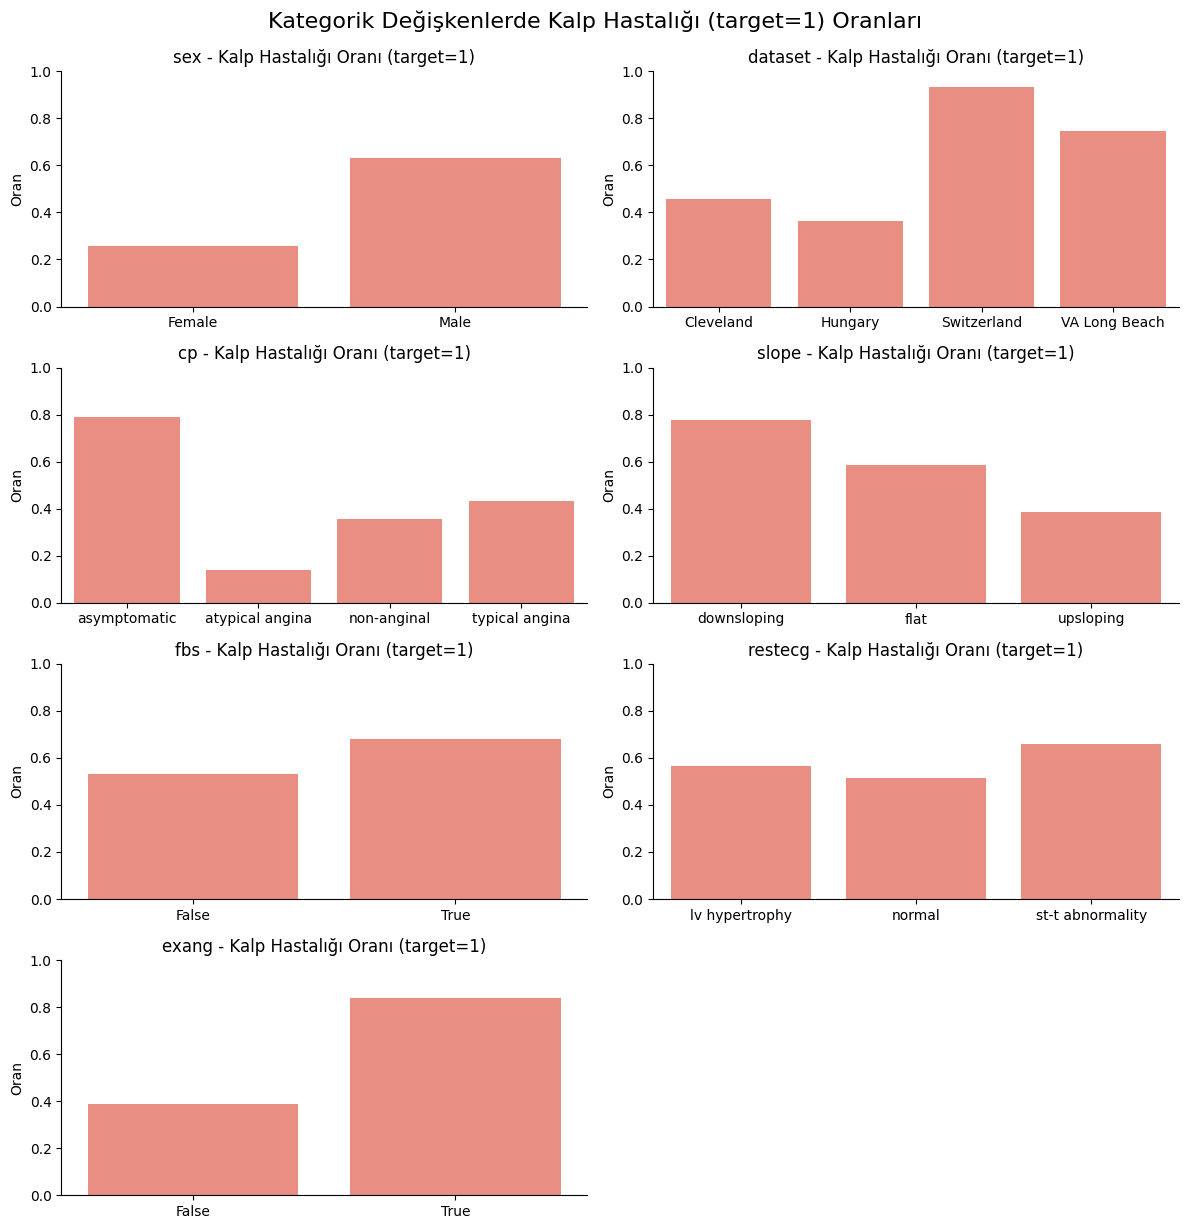

## Veri Ön İşleme Süreci


### Değişkenlerin Tanımı

**Temizlenmiş Verideki Değişkenler:**
`['age', 'sex', 'dataset', 'cp', 'target', 'trestbps', 'chol', 'thalch', 'oldpeak', 'slope', 'fbs', 'restecg', 'exang']`

* **Kategorik Değişkenler:** `sex`, `dataset`, `cp`, `slope`, `fbs`, `restecg`, `exang`
* **Sayısal Değişkenler:** `age`, `trestbps`, `chol`, `thalch`, `oldpeak`

### Encoding İşlemleri

#### Label Encoding – Binary Değişkenler

| Değişken | Benzersiz Değerler (Önce) | Benzersiz Değerler (Sonra) | Mapping                  |
| -------- | ------------------------- | -------------------------- | ------------------------ |
| `sex`    | \['Male', 'Female']       | \[1, 0]                    | {'Female': 0, 'Male': 1} |
| `fbs`    | \[True, False]            | \[1, 0]                    | {False: 0, True: 1}      |
| `exang`  | \[False, True]            | \[0, 1]                    | {False: 0, True: 1}      |

#### One-Hot Encoding – Çok Kategorili Değişkenler

Öncesi (benzersiz değerler):

* `dataset`: \['Cleveland', 'Hungary', 'Switzerland', 'VA Long Beach']
* `cp`: \['typical angina', 'asymptomatic', 'non-anginal', 'atypical angina']
* `restecg`: \['lv hypertrophy', 'normal', 'st-t abnormality']
* `slope`: \['downsloping', 'flat', 'upsloping']

Sonrası (oluşan sütunlar):

* `dataset_Hungary`, `dataset_Switzerland`, `dataset_VA Long Beach`
* `cp_atypical angina`, `cp_non-anginal`, `cp_typical angina`
* `restecg_normal`, `restecg_st-t abnormality`
* `slope_flat`, `slope_upsloping`

### Sayısal Değişkenlerin Ölçeklendirilmesi

Ölçeklenen Değişkenler: `age`, `trestbps`, `chol`, `thalch`, `oldpeak`

* Yöntem: `StandardScaler`

```python
scaler = StandardScaler()
df_encoded[num_cols] = scaler.fit_transform(df_encoded[num_cols])
```

### Modelleme Öncesi ve Sonrası Karşılaştırma

| Özellik    | Modelleme Öncesi (mean ± std) | Modelleme Sonrası (mean ± std) | Açıklama                             |
| ---------- | ----------------------------- | ------------------------------ | ------------------------------------ |
| `age`      | 53.5 ± 9.42                   | \~0 ± 1.00                     | StandardScaler uygulandı             |
| `trestbps` | 130.9 ± 15.62                 | \~0 ± 1.00                     | StandardScaler uygulandı             |
| `chol`     | 206.6 ± 92.54                 | \~0 ± 1.00                     | StandardScaler uygulandı             |
| `thalch`   | 137.7 ± 25.35                 | \~0 ± 1.00                     | StandardScaler uygulandı             |
| `oldpeak`  | 0.82 ± 0.95                   | \~0 ± 1.00                     | StandardScaler uygulandı             |
| `sex`      | 0.79 ± 0.41                   | Aynı kaldı (Label encoded)     | Binary olduğu için scaling gerekmedi |
| `fbs`      | 0.15 ± 0.36                   | Aynı kaldı (Label encoded)     | Binary                               |
| `exang`    | 0.37 ± 0.48                   | Aynı kaldı (Label encoded)     | Binary                               |
| `target`   | 0.55 ± 0.50                   | Aynı (değiştirilmedi)          | Hedef değişken                       |


* Sayısal değişkenlerin tamamı başarıyla normalize edildi (ortalama ≈ 0, standart sapma ≈ 1).
* Binary değişkenler (`sex`, `fbs`, `exang`) zaten 0–1 formatında olduğundan ölçeklendirmeye gerek kalmadı.
* `target` sütunu hedef değişken olduğundan olduğu gibi bırakıldı.

Veri artık modellemeye uygun, dengelenmiş ve temizlenmiş bir forma dönüştürülmüştür.


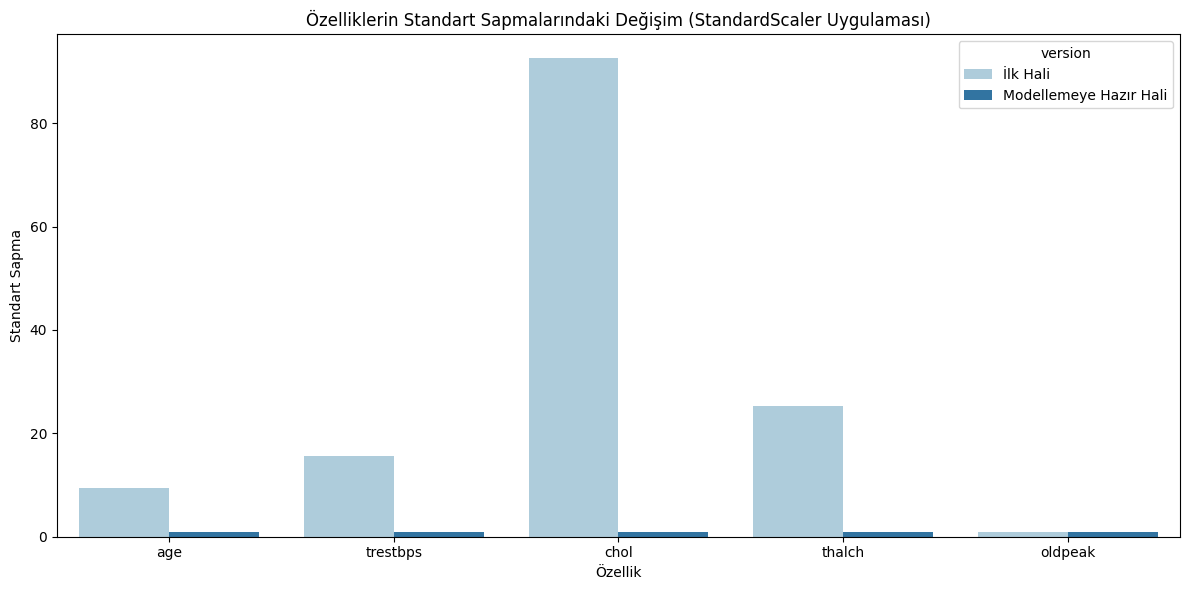

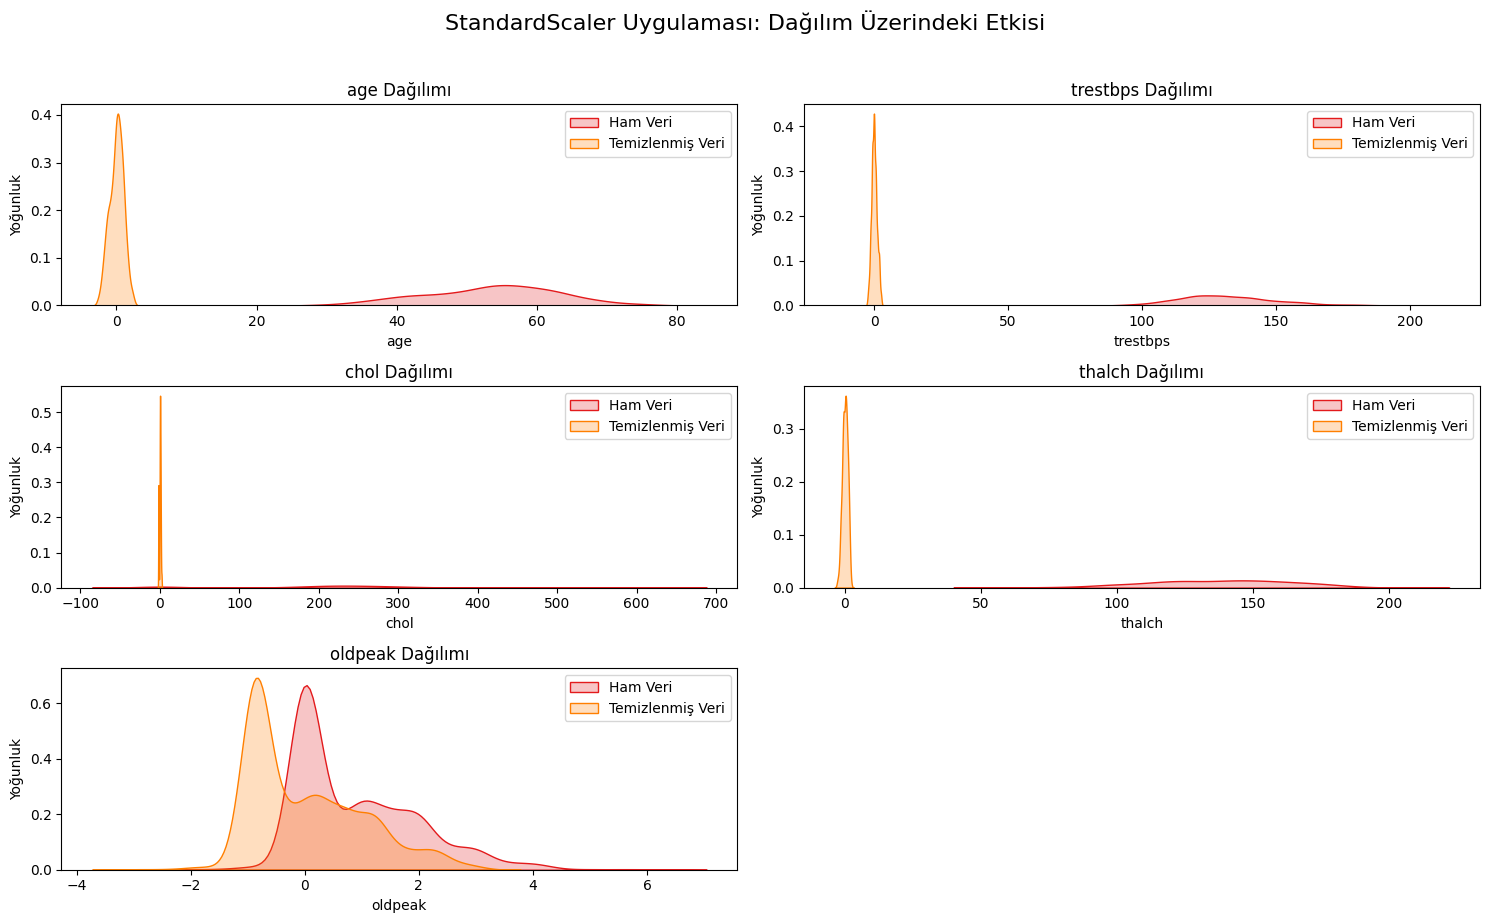

## Hedef Değişken ile Özellikler Arasındaki İlişkiler

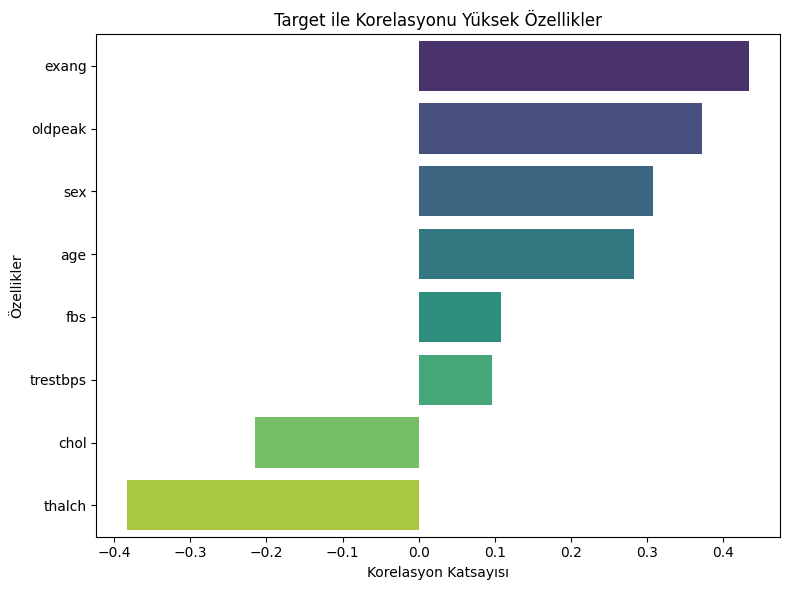

## Hedef Değişken ile Özellikler Arasındaki İlişkiler

### Korelasyon Analizi Sonuçları

Target (kalp hastalığı) ile en yüksek korelasyon gösteren değişkenler şunlardır:

| Değişken  | Korelasyon | Yorum                                                                              |
| --------- | ---------- | ---------------------------------------------------------------------------------- |
| `exang`   | +0.45      | Egzersize bağlı anjina yaşayan bireylerde hastalık oranı belirgin şekilde artıyor. |
| `oldpeak` | +0.40      | ST depresyonu arttıkça kalp hastalığı riski de artmakta.                           |
| `sex`     | +0.30      | Erkeklerde hastalık oranı kadınlara göre daha yüksek.                              |
| `age`     | +0.28      | Yaş arttıkça kalp hastalığı riski artmakta.                                        |
| `thalch`  | -0.38      | Maksimum kalp atış hızı düştükçe hastalık riski yükseliyor.                        |

### Özellik Bazlı Görsel İncelemeler

#### Egzersize Bağlı Anjina (exang)
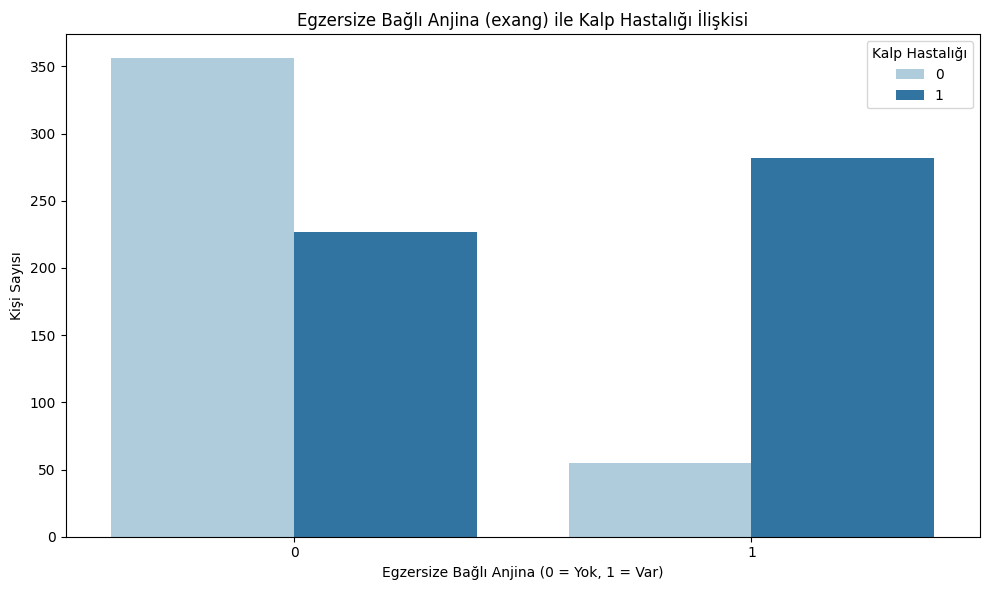



* Egzersizle anjina yaşayan bireylerin büyük kısmı kalp hastası çıkmıştır.
* Egzersiz yaparken göğüs ağrısı yaşayan bireyler riskli gruptadır.



#### ST Depresyonu (oldpeak)

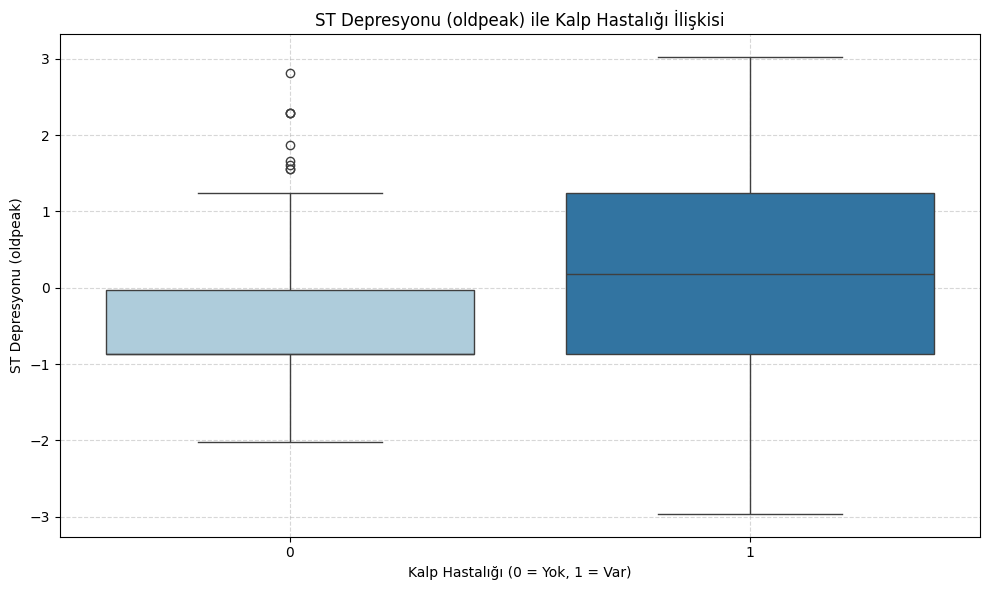

* Kalp hastalığı olan bireylerin `oldpeak` değeri genel olarak daha yüksektir.
* ST segment depresyonu ciddi klinik belirteçlerden biridir.



#### Maksimum Kalp Atış Hızı (thalch)

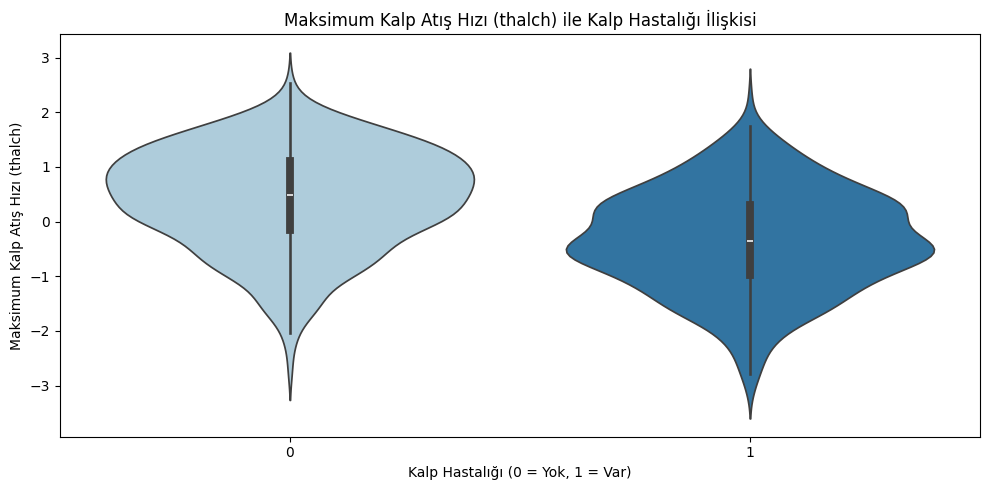

* Kalp hastalığı olmayan bireylerde `thalch` değerleri daha yüksektir.
* Düşük `thalch`, zayıf kardiyovasküler kondisyonun işareti olabilir.



#### Cinsiyet (sex)


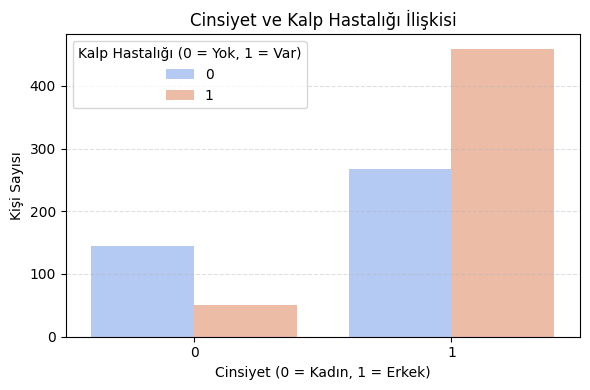

* Erkeklerde kalp hastalığı prevalansı belirgin şekilde daha yüksektir.
* Cinsiyet, risk sınıflandırmasında dikkate alınmalıdır.




#### Yaş (age)

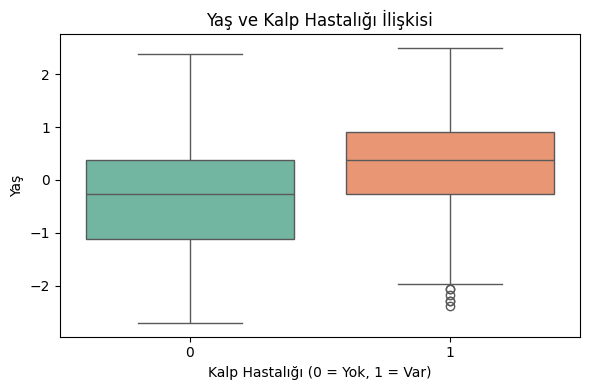

* Hastalığa sahip bireylerin yaş ortalaması daha yüksektir.
* Yaş arttıkça kalp hastalığı riski de artmaktadır.



#### Yaş Gruplarına Göre Hastalık Oranı

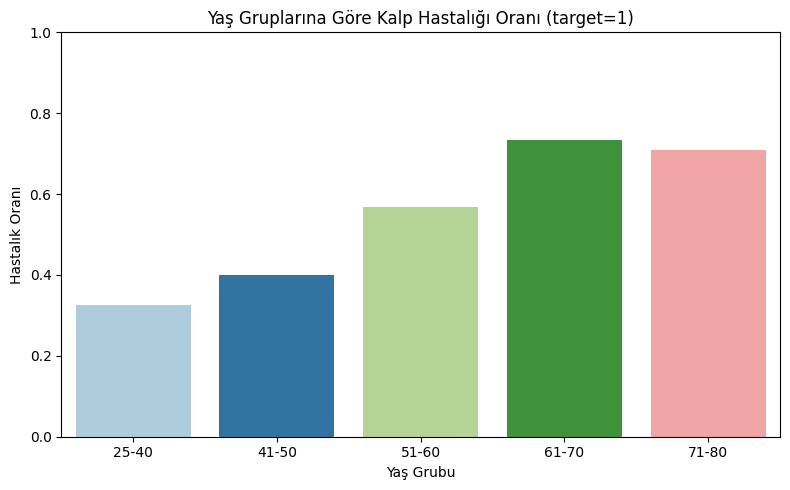

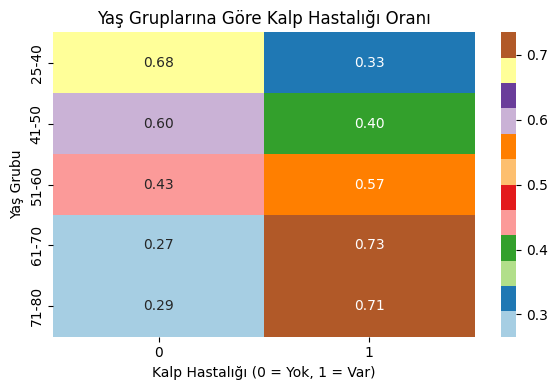


| Yaş Grubu | Hastalık Oranı (target=1) |
| --------- | ------------------------- |
| 25–40     | %33                       |
| 41–50     | %40                       |
| 51–60     | %57                       |
| 61–70     | %73                       |
| 71–80     | %71                       |

> Bu gözlemler ışığında, `exang`, `oldpeak`, `thalch`, `age` ve `sex` değişkenleri, model için en güçlü belirleyiciler arasında yer almaktadır.

## Modelleme






> *%80 eğitim, %20 test   |   Test setinde sınıf dağılımı dengelidir (1: %55, 0: %45)*

| Model                   | AUC  | FN | FP | Mean Accuracy (CV) | Test Accuracy | Train Accuracy | Overfitting Farkı | Notlar                             |
| ----------------------- | ---- | -- | -- | ------------------ | ------------- | -------------- | ----------------- | ---------------------------------- |
| **Logistic Regression** | 0.91 | 13 | 19 | 0.77               | 0.83          | 0.83           | 0.00              | Dengeli ve overfitting yok         |
| **Random Forest**       | 0.91 | 13 | 16 | 0.73               | 0.84          | 1.00           | 0.16              | Aşırı öğrenme eğilimi              |
| **KNN**                 | 0.88 | 9  | 21 | 0.72               | 0.84          | 0.85           | 0.01              | En düşük FN, stabil                |
| **SVM**                 | 0.90 | 10 | 20 | 0.75               | 0.84          | 0.86           | 0.02              | Dengeli, genel başarı yüksek       |
| **XGBoost**             | 0.90 | 17 | 16 | 0.68               | 0.82          | 1.00           | 0.18              | Aşırı öğrenme net                  |
| **Gradient Boosting**   | 0.91 | 12 | 16 | 0.65               | 0.85          | 0.92           | 0.07              | ROC güçlü, overfitting orta        |
| **CatBoost**            | 0.91 | 12 | 18 | 0.71               | 0.84          | 0.96           | 0.12              | Güçlü ayırıcı ama overfit eğilimli |

---



* **Lojistik Regresyon ve SVM**: Hem test doğruluğu hem CV ortalaması yüksek, overfitting yok → **güvenilir**.
* **KNN**: FN değeri en düşük, hasta kaçırma riski minimum → **medikal uygulamalarda avantajlı**.
* **XGBoost, RF, CatBoost**: Eğitim setinde aşırı başarı → **overfitting riski yüksek**.
* **Gradient Boosting**: AUC iyi, CV skor düşük → **karma performans**.




## Model Performans Karşılaştırması (Tuning Sonrası)


| Model                   | AUC  | FN | FP | Mean Accuracy (CV) | Test Accuracy | Train Accuracy | Fark (Train - Test) | Notlar                   |
| ----------------------- | ---- | -- | -- | ------------------ | ------------- | -------------- | ------------------- | ------------------------ |
| **Logistic Regression** | 0.91 | 13 | 19 | 0.819              | 0.83          | 0.83           | 0.00                | Dengeli, overfitting yok |
| **Random Forest**       | 0.91 | 13 | 16 | 0.818              | 0.84          | 1.00           | 0.16                | Aşırı öğrenme riski var  |
| **KNN**                 | 0.88 | 9  | 21 | 0.804              | 0.84          | 0.85           | 0.01                | En düşük FN, istikrarlı  |
| **SVM**                 | 0.90 | 10 | 20 | 0.818              | 0.84          | 0.86           | 0.02                | Dengeli, düşük fark      |
| **XGBoost**             | 0.90 | 17 | 16 | 0.814              | 0.82          | 1.00           | 0.18                | Aşırı öğrenme gözlenmiş  |
| **Gradient Boosting**   | 0.91 | 12 | 16 | 0.803              | 0.85          | 0.92           | 0.07                | Orta düzey overfitting   |
| **CatBoost**            | 0.91 | 12 | 18 | 0.807              | 0.84          | 0.96           | 0.12                | Overfitting riski var    |

---


* **Logistic Regression** ve **SVM**, yüksek **AUC**, düşük **overfitting farkı** ile güvenilir ve dengeli sonuçlar sunar.
* **KNN**, en düşük **FN** değeri ile hasta kaçırma riskini minimize eder. Ancak **FP** değeri görece yüksektir.
* **XGBoost** ve **Random Forest**, yüksek eğitim doğruluğu nedeniyle aşırı öğrenme riskine sahiptir.
* **Gradient Boosting** ve **CatBoost**, orta seviyede overfitting gösterse de genel doğrulukları yüksektir.

>  Klinik uygulamalarda **hasta kaçırma (FN)** kritik olduğundan, **Recall** oranı yüksek ve **overfitting riski düşük** modeller (örn. **KNN, SVM, Logistic Regression**) daha tercih edilebilir seçeneklerdir.



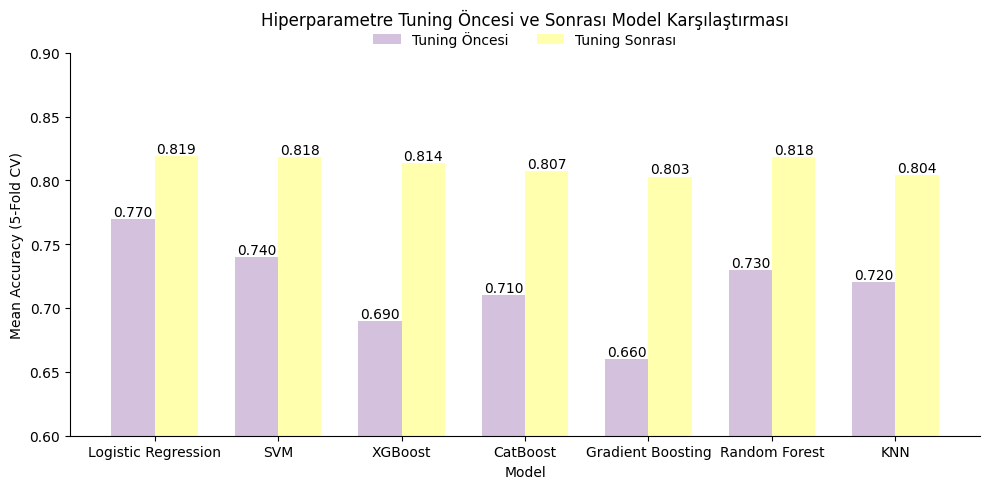



# Sonuç ve Değerlendirme

Bu projede, kalp hastalığı riskinin tahmini amacıyla farklı makine öğrenmesi sınıflandırma algoritmaları karşılaştırılmıştır. Veri ön işleme adımlarından başlayarak hiperparametre tuning süreci dahil tüm modelleme adımları detaylıca uygulanmıştır.

Elde edilen sonuçlara göre:

* **En iyi genel performans** Gradient Boosting modeline ait olup, test doğruluğu en yüksektir (%85).
* **En yüksek güvenilirlik ve istikrar**, overfitting riski taşımayan ve tüm metriklerde dengeli sonuçlar veren **Lojistik Regresyon** ve **SVM** modellerindedir.
* **Hasta kaçırma oranı** açısından en iyi model **KNN** olup en düşük False Negative sayısına sahiptir.
* **XGBoost ve Random Forest** modelleri eğitim verisine aşırı uyum sağlamış ve test doğruluğu ile arada ciddi farklar gözlenmiştir.

Bu değerlendirmeler ışığında, sağlık gibi hassas bir alanda kullanılacak modellerde hasta kaçırmama önceliklidir. Bu nedenle:

* **KNN** modeli hasta tespiti açısından avantajlıdır.
* **SVM ve Lojistik Regresyon**, hem yorumlanabilirlik hem de genel güvenilirlik açısından tercih edilebilir modellerdir.

Veri dengeli olduğu için metrikler güvenilirdir, ancak gerçek hayatta dengesiz veri ile karşılaşılabileceği unutulmamalıdır. Bu durumda ROC-AUC ve Recall gibi metrikler daha öncelikli değerlendirme kriterleri olmalıdır.



Kalp hastalıkları, dünyada en yaygın ölüm nedenleri arasında yer almaktadır. Bu nedenle, **erken teşhis ve risk belirleme** çalışmaları klinik açıdan hayati öneme sahiptir. Bu projede geliştirilen modeller, bir bireyin kalp hastalığı riski taşıyıp taşımadığını veriye dayalı olarak tahmin etme kapasitesine sahiptir.

* **False Negative (FN)** sayısı özellikle kritik bir metriktir çünkü hasta bireylerin sağlıklı olarak sınıflandırılması, potansiyel bir tedavi fırsatının kaçırılması anlamına gelir.
* Bu bağlamda, **KNN modeli**, en düşük FN değeriyle hasta kaçırma riskini azaltması açısından öne çıkmaktadır.
* **Lojistik Regresyon** ise medikal alanda yaygın kullanımı ve açıklanabilir yapısıyla doktorların karar süreçlerine destek olabilecek güvenilir bir modeldir.


